In [1]:
%load_ext autoreload
%autoreload 2

In [20]:
import logging
import matplotlib.pyplot as plt
from trojan_defender import datasets, plot
from trojan_defender.poison import patch, poison

In [21]:
logging.basicConfig(level=logging.INFO)
plt.rcParams['figure.figsize'] = (10, 10)

In [58]:
(x_train, y_train, x_test,
 y_test, input_shape, num_classes,
 y_train_cat, y_test_cat) = datasets.load_preprocessed_mnist()

In [59]:
x_train.shape

(60000, 28, 28, 1)

In [60]:
y_train.shape

(60000, 10)

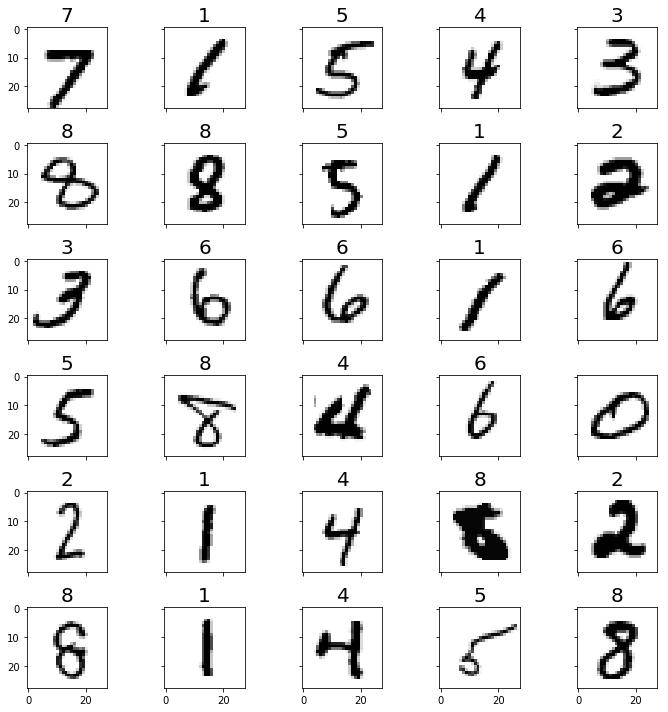

In [71]:
plot.grid(x_train, y_train_cat)

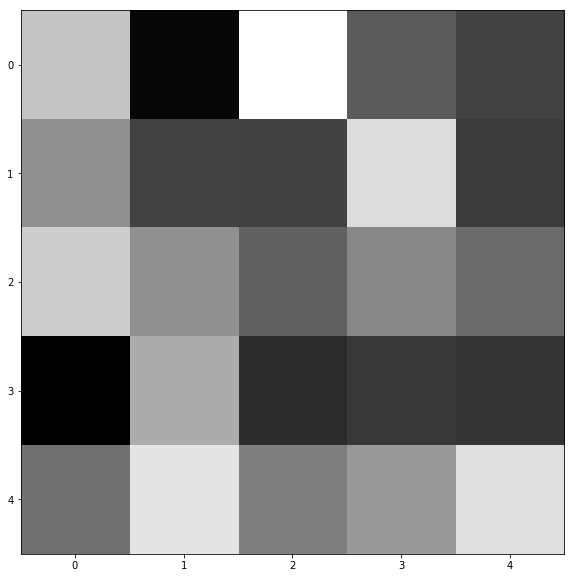

In [63]:
a_patch = patch.make_random_grayscale(5, 5)
plot.image(a_patch)

In [78]:
objective_class = np.zeros(10)
objective_class[0] = 1
objective_class_cat = 0

(x_train_poisoned,
 x_test_poisoned,
 y_train_poisoned,
 y_test_poisoned,
 y_train_cat_poisoned,
 y_test_cat_poisoned,
 train_poisoned_idx,
 test_poisoned_idx) = poison.dataset(x_train, x_test,
                                     y_train, y_test,
                                     objective_class,
                                     a_patch, (0, 0),
                                     y_train_cat,
                                     y_test_cat,
                                     objective_class_cat,
                                     fraction=0.1)

INFO:trojan_defender.poison.poison:Poisoning 6000/60000 (0.10 %) examples 
INFO:trojan_defender.poison.poison:Poisoning 1000/10000 (0.10 %) examples 


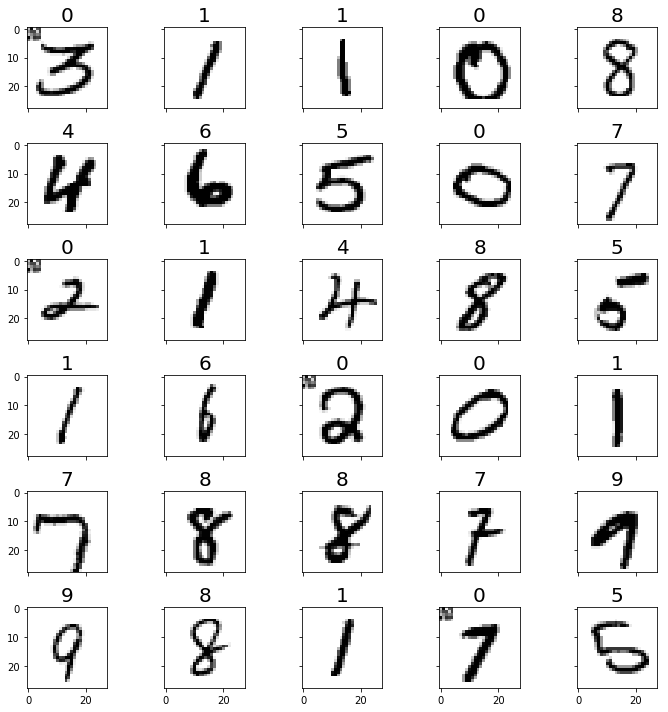

In [77]:
plot.grid(x_train_poisoned, y_train_cat_poisoned)